# Practical Machine Learning for Physicists
## Week 4 Exercise - Part 2


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.9.2


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [1]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

.

.

.

__________________________________________________________________
# A Bottleneck of Nine

In this section, we will be trying to make an accurate (loss = 0.02 or lower) auto-encoder with a bottle-neck of 9 neurons. 

The activation will be kept as 'relu', as it seems to generate sharper guesses as comapred to the 'smoother' guesses of sigmoid, which can be seen by the graphs they symbolize.

In [55]:
modela=keras.models.Sequential()                                                                    #load a keras-model in 'model'

#First lets convolute and downsmaple the data.
modela.add(keras.layers.Conv2D(5,3,input_shape=(None,None,1),                                       #Add a convolution layer. 5 of 3x3 kernels are applied to the image.
               activation="relu",padding='same'))
modela.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down                    #Add a pooling layer (2x2 dimensions) that downsamples from 28x28 to 14x14. Avg-pooling smooths-out the image.
modela.add(keras.layers.Conv2D(5,5,
               activation="relu",padding='same'))
modela.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
modela.add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))



#And now we upsample the data to bring it to the original dimensions.
modela.add(keras.layers.UpSampling2D(size=(3,3))) # up                                              #Add a pooling layer (2x2 dimensions) that upsamples (for example, from 14^2 to 28^2). Avg-pooling smooths-out the image.
modela.add(keras.layers.Conv2D(5,5,
               activation="relu",padding='same'))
modela.add(keras.layers.UpSampling2D(size=(3,3))) # up
modela.add(keras.layers.Conv2D(5,5,
               activation="relu",padding='same'))
modela.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))                             #Add an output layer that produces a 28x28 image that is supposed to imitate (to some extent) the input image.



modela.compile(loss='mean_squared_error',
              optimizer='adam')                                                                     #Compile the model and store it's loss values for possible future use.

modela.summary()                                                                                    #Give a summary of the layers in the model and their parameters and output shapes.

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, None, None, 5)     50        
                                                                 
 average_pooling2d_29 (Avera  (None, None, None, 5)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_85 (Conv2D)          (None, None, None, 5)     630       
                                                                 
 average_pooling2d_30 (Avera  (None, None, None, 5)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_86 (Conv2D)          (None, None, None, 1)     46        
                                                                 
 up_sampling2d_29 (UpSamplin  (None, None, None, 1)  

Text(0, 0.5, 'Cost')

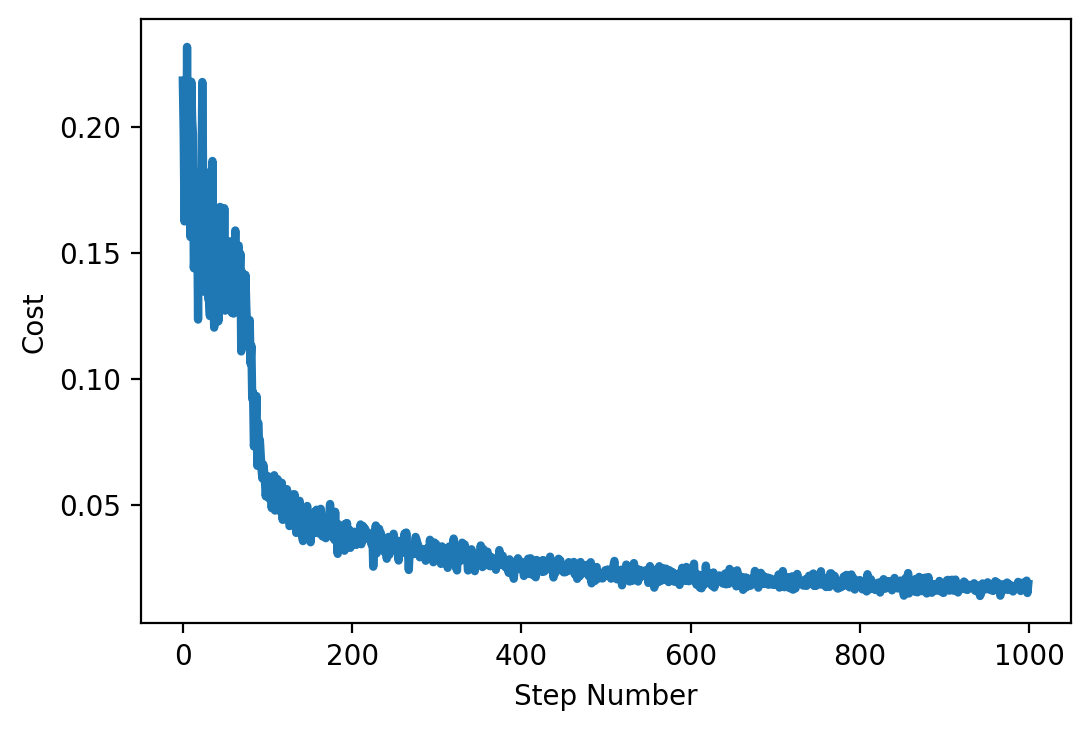

In [56]:
#Now we can do the actual model training. Here, batchsize and steps are related such that their product is 30,000. 
steps=1000                                                                                        #Number of steps the model should take in training
cost,y_target=generate_and_train(modela,circle_generator,img_size=9*3,batchsize=30,steps=steps)   #train the model and generate the cost values to plot and see how the model performs.

#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps)                                                                        
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

I prioritized the number steps heavily over the batchsize so as to focus on the model learning in small but quick steps over time rather than running large learning rounds, as that may lead to ineffecient testing. Big mistakes can still be identified faster with smaller batchsizes, and more mistakes are corrected over more steps.

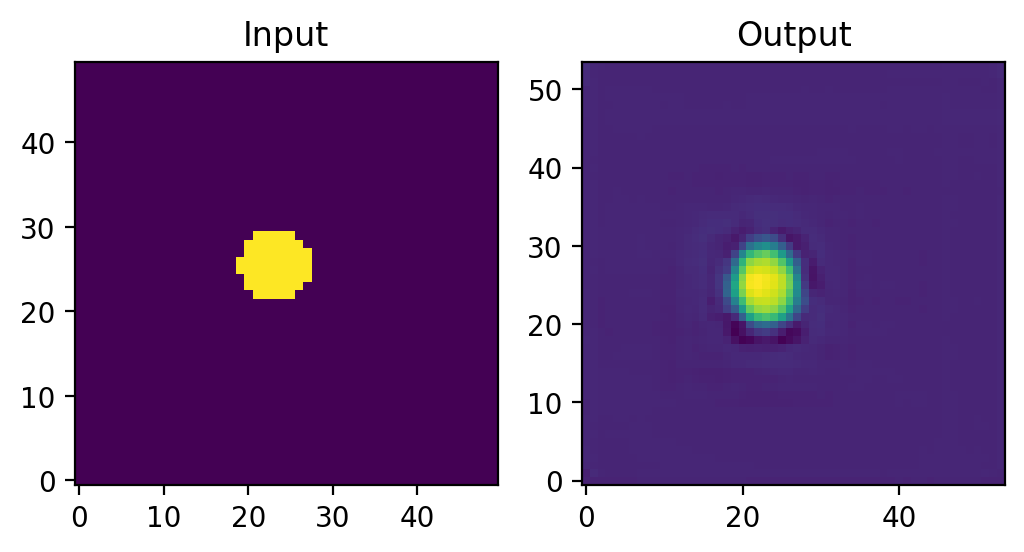

In [57]:
#Plot the test image and the output from the model to compare. 
plot_test_image(modela,circle_generator,50)

In [58]:
print_layers(modela,y_target)             #Prints out the neural-structure of this model.
cost[-1]                                  #Display the final cost of the fitting.

Layer 0: 3645 neurons /  (30, 27, 27, 5)
Layer 1: 405 neurons /  (30, 9, 9, 5)
Layer 2: 405 neurons /  (30, 9, 9, 5)
Layer 3: 45 neurons /  (30, 3, 3, 5)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 405 neurons /  (30, 9, 9, 5)
Layer 7: 3645 neurons /  (30, 27, 27, 5)
Layer 8: 3645 neurons /  (30, 27, 27, 5)
Layer 9: 729 neurons /  (30, 27, 27, 1)


0.019879307597875595

**Looking at the input and output images above, we can see that a bottleneck of 9-neurons still allows for pretty good representation of size, shape and location of object, giving us a final cost of about 0.19.**

__________________________________________________________________
# A Bottleneck of Three!

In this section, we will be trying to make an auto-encoder with a bottle-neck of 3 neurons. To ensure some quality control, we will aim to achieve cost values not much bigger than for 9-neurons above. Also, we'll aim to generate output images that somewhat approximate the input image.

In the cell below, I maintained a similar structure to the 9-neuron challenge, but added an extra of dowsmapling and upsampling along with changing one of the convolution lines to result in the bottle neck.

In [67]:
modelb=keras.models.Sequential()

#First, we convolute and downsample the data.
modelb.add(keras.layers.Conv2D(5,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
modelb.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
modelb.add(keras.layers.Conv2D(5,5,
               activation="relu",padding='same'))
modelb.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
modelb.add(keras.layers.Conv2D(3,3,
               activation="relu",padding='same'))
modelb.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down         



#Next, we upsample the data to get it to the same dimensions as the 
modelb.add(keras.layers.UpSampling2D(size=(3,3))) # up
modelb.add(keras.layers.Conv2D(4,5,
               activation="relu",padding='same'))
modelb.add(keras.layers.UpSampling2D(size=(3,3))) # up
modelb.add(keras.layers.Conv2D(5,5,
               activation="relu",padding='same'))
modelb.add(keras.layers.UpSampling2D(size=(3,3))) # up
modelb.add(keras.layers.Conv2D(5,5,
               activation="relu",padding='same'))
modelb.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))



modelb.compile(loss='mean_squared_error',
              optimizer='adam')                                                                     #Compile the model and store it's loss values for possible future use.


modelb.summary()                                                                                    #Give a summary of the layers in the model and their parameters and output shapes.

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, None, None, 5)     130       
                                                                 
 average_pooling2d_37 (Avera  (None, None, None, 5)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_106 (Conv2D)         (None, None, None, 5)     630       
                                                                 
 average_pooling2d_38 (Avera  (None, None, None, 5)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_107 (Conv2D)         (None, None, None, 3)     138       
                                                                 
 average_pooling2d_39 (Avera  (None, None, None, 3)  

Text(0, 0.5, 'Cost')

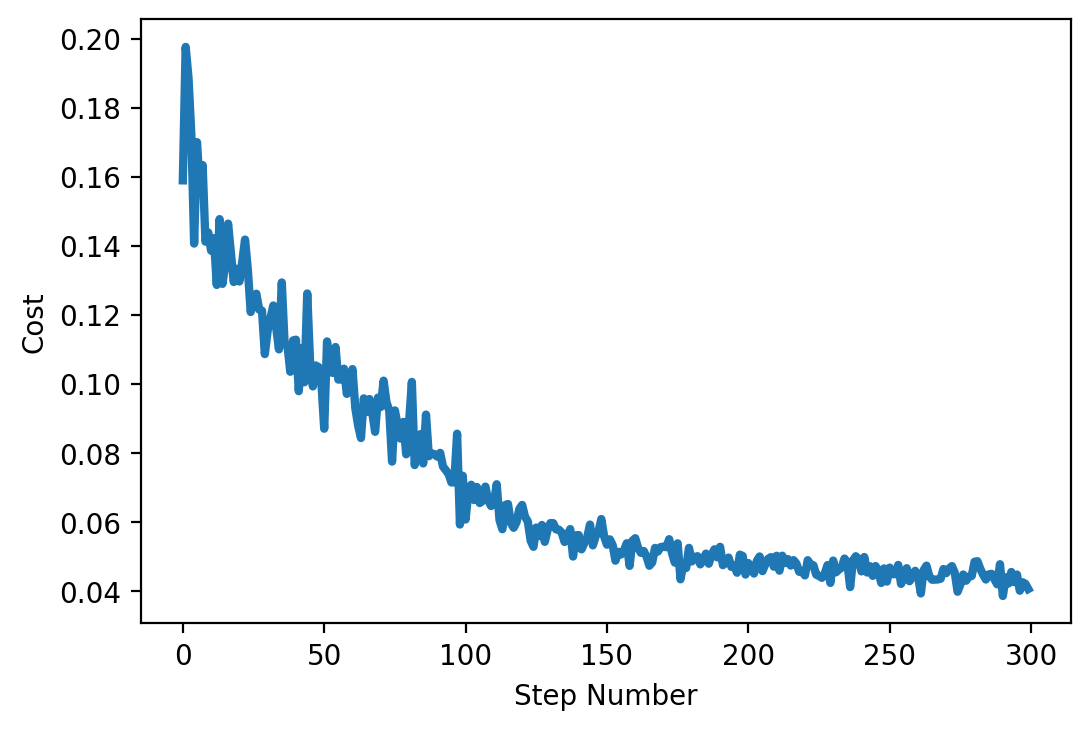

In [68]:
#Now we can do the actual model training
steps=300
cost,y_target=generate_and_train(modelb,circle_generator,img_size=9*3,batchsize=100,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

**When I ran the training with 3000 steps and 10 images like the previous task, I got bad cost values and output images. So I assumed that the batchsize was not big enough to train satisfactorily, so as a result, I increased the batch size and decreased the number of steps to give more room to learn in each step.** 

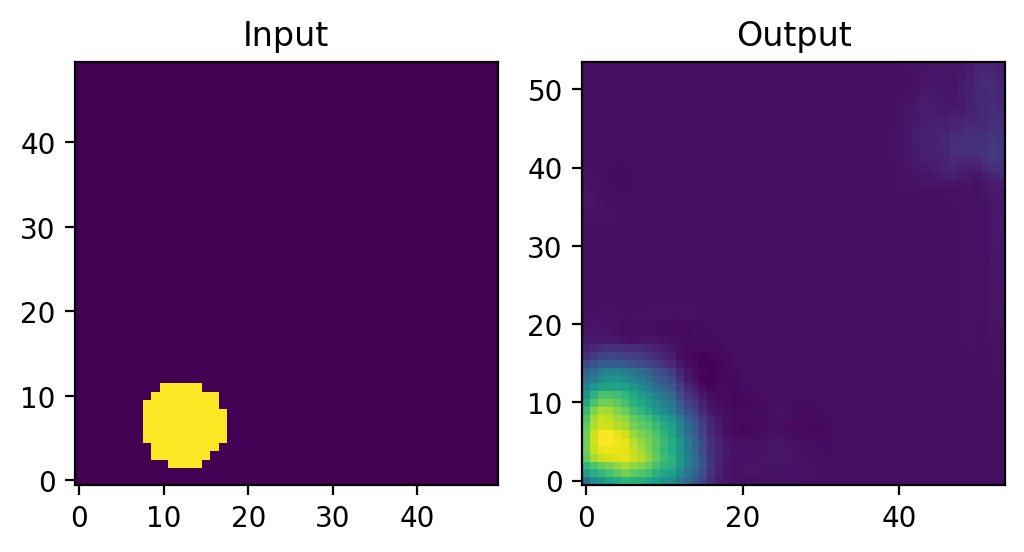

In [69]:
plot_test_image(modelb,circle_generator,50)

**The output image is a somewhat decent approximation of the input. The shape seems to be a slightly mis-shapen gaussian blur of the original, the size is a pretty good approximate of the original, and the location, although slightly off, is still in the correct corner of the image, which is pretty good.**

In [70]:
print_layers(modelb,y_target)             #Prints out the neural-structure of this model.
print('The cost is', cost[-2])            #Display the final cost of the fitting.

Layer 0: 3645 neurons /  (100, 27, 27, 5)
Layer 1: 405 neurons /  (100, 9, 9, 5)
Layer 2: 405 neurons /  (100, 9, 9, 5)
Layer 3: 45 neurons /  (100, 3, 3, 5)
Layer 4: 27 neurons /  (100, 3, 3, 3)
Layer 5: 3 neurons /  (100, 1, 1, 3)
Layer 6: 27 neurons /  (100, 3, 3, 3)
Layer 7: 36 neurons /  (100, 3, 3, 4)
Layer 8: 324 neurons /  (100, 9, 9, 4)
Layer 9: 405 neurons /  (100, 9, 9, 5)
Layer 10: 3645 neurons /  (100, 27, 27, 5)
Layer 11: 3645 neurons /  (100, 27, 27, 5)
Layer 12: 729 neurons /  (100, 27, 27, 1)
The cost is 0.042085886001586914


**The cost of the model was about 2x than for 9-neurons, which is pretty good. And as we said above, the image approximation is also pretty good.**

**Regarding the structure, I did not run convolution on the 3-neuron layer as it would have just lead to more cost in the end.**